In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import invgamma, norm, dirichlet

plt.style.use("seaborn-v0_8")

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DATA_PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
FIGURES_DIR = os.path.join(PROJECT_ROOT, "results", "figures")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")

os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Python executable:", sys.executable)
print("Processed data dir:", DATA_PROCESSED_DIR)
print("Figures dir:", FIGURES_DIR)
print("Results dir:", RESULTS_DIR)


Python executable: c:\DAT494\bayesian_regime_switching\.venv\Scripts\python.exe
Processed data dir: c:\DAT494\bayesian_regime_switching\data\processed
Figures dir: c:\DAT494\bayesian_regime_switching\results\figures
Results dir: c:\DAT494\bayesian_regime_switching\results


In [3]:
TICKER = "^GSPC"
PROCESSED_FILE = os.path.join(
    DATA_PROCESSED_DIR,
    f"{TICKER.replace('^', '')}_returns_processed.csv"
)

data = pd.read_csv(PROCESSED_FILE, parse_dates=['Date'], index_col='Date')
data.head()


,AdjClose,SimpleReturn,LogReturn,RollingVol_21,CumReturn
Date,,,,,
2000-01-04,1399.420044,-0.038345,-0.039099,NaN,0.961655
2000-01-05,1402.109985,0.001922,0.001920,NaN,0.963504
2000-01-06,1403.449951,0.000956,0.000955,NaN,0.964425
2000-01-07,1441.469971,0.027090,0.026730,NaN,0.990551
2000-01-10,1457.599976,0.011190,0.011128,NaN,1.001635


In [4]:
r = data['LogReturn'].values  # numpy array
T = len(r)

print("Number of time points:", T)
print("Sample mean:", r.mean())
print("Sample std:", r.std())

assert not np.isnan(r).any(), "LogReturn contains NaNs"


Number of time points: 6516
Sample mean: 0.00023771619123853105
Sample std: 0.01223060314141002


## Use empirical results to choose priors

In [5]:
# Recrate rolling vol & pseudo-regime labels

if 'RollingVol_21' not in data.columns:
    data['RollingVol_21'] = data['LogReturn'].rolling(21).std()

vol = data['RollingVol_21']

high_vol_threshold = vol.quantile(0.75)
low_vol_threshold = vol.quantile(0.25)

def classify_vol_regime(v, low_thr, high_thr):
    if np.isnan(v):
        return np.nan
    if v <= low_thr:
        return "low_vol"
    elif v >= high_thr:
        return "high_vol"
    else:
        return "mid_vol"

data['VolRegime'] = data['RollingVol_21'].apply(
    lambda x: classify_vol_regime(x, low_vol_threshold, high_vol_threshold)
)

regime_stats = (
    data.dropna(subset=['VolRegime'])
        .groupby('VolRegime')['LogReturn']
        .agg(['mean', 'std', 'count'])
        .sort_values('std')
)

regime_stats


,mean,std,count
VolRegime,,,
low_vol,0.000567,0.005190,1624
mid_vol,0.000126,0.009001,3248
high_vol,0.000156,0.020202,1624


In [6]:
low_vol_mean = regime_stats.iloc[0]['mean']
low_vol_std = regime_stats.iloc[0]['std']

high_vol_mean = regime_stats.iloc[-1]['mean']
high_vol_std = regime_stats.iloc[-1]['std']

print("Low-vol regime (empirical): mean =", low_vol_mean, ", std =", low_vol_std)
print("High-vol regime (empirical): mean =", high_vol_mean, ", std =", high_vol_std)


Low-vol regime (empirical): mean = 0.0005667321594948332 , std = 0.005190374406734077
High-vol regime (empirical): mean = 0.0001556186177174339 , std = 0.020202133449965163


## Define Bayesian HMM Model (Conjugate Structure)

In [7]:
# Set Hyperparameters for Priors

# Hyperparameters for Normal-Inverse-Gamma prior
# Use overall stats as a rough scale
overall_mean = r.mean()
overall_std = r.std()

# Prior mean for both regimes around overall mean
m0 = overall_mean
kappa0 = 5.0   # how strongly we trust m0

# Use variance scale based on overall std
alpha0 = 3.0   # shape > 2 so variance has finite mean
beta0 = (overall_std ** 2) * (alpha0 - 1)  # centers prior variance near overall_std^2

print("Overall mean:", overall_mean, "Overall std:", overall_std)
print("NIG prior: m0 =", m0, ", kappa0 =", kappa0, ", alpha0 =", alpha0, ", beta0 =", beta0)

# Dirichlet priors for transition matrix (favor persistence)
A_alpha = np.array([
    [10.0, 1.0],   # from state 0: mostly stay in 0
    [1.0, 10.0]    # from state 1: mostly stay in 1
])


Overall mean: 0.00023771619123853105 Overall std: 0.01223060314141002
NIG prior: m0 = 0.00023771619123853105 , kappa0 = 5.0 , alpha0 = 3.0 , beta0 = 0.0002991753064053373


## Core Gibbs Sampler Components

In [8]:
# Sample Transition Matrix

def sample_transition_matrix(states, A_alpha):
    """
    Sample transition matrix A from Dirichlet posteriors given a state sequence.
    states: array of shape (T,) with values 0 or 1
    """
    K = 2
    counts = np.zeros((K, K), dtype=int)
    for t in range(len(states) - 1):
        i = states[t]
        j = states[t + 1]
        counts[i, j] += 1

    A = np.zeros((K, K))
    for i in range(K):
        A[i, :] = dirichlet.rvs(A_alpha[i, :] + counts[i, :])[0]

    return A


In [9]:
# Sample Means and Variances (Normal-Inverse-Gamma Posterior)

def sample_means_variances(r, states, m0, kappa0, alpha0, beta0):
    """
    Sample (mu_k, sigma_k^2) for k=0,1 using conjugate Normal-Inverse-Gamma posterior.
    """
    K = 2
    mus = np.zeros(K)
    sigmas2 = np.zeros(K)

    for k in range(K):
        idx = (states == k)
        n_k = idx.sum()

        if n_k > 0:
            r_k = r[idx]
            mean_k = r_k.mean()
            ss_k = ((r_k - mean_k) ** 2).sum()

            # Posterior hyperparameters
            kappa_n = kappa0 + n_k
            m_n = (kappa0 * m0 + n_k * mean_k) / kappa_n
            alpha_n = alpha0 + n_k / 2.0
            beta_n = beta0 + 0.5 * ss_k + (kappa0 * n_k * (mean_k - m0) ** 2) / (2 * kappa_n)

        else:
            # No observations in this state: fallback to prior
            kappa_n = kappa0
            m_n = m0
            alpha_n = alpha0
            beta_n = beta0

        # Sample sigma^2 from Inv-Gamma(alpha_n, beta_n)
        sigma2_k = invgamma.rvs(a=alpha_n, scale=beta_n)
        mu_k = norm.rvs(loc=m_n, scale=np.sqrt(sigma2_k / kappa_n))

        mus[k] = mu_k
        sigmas2[k] = sigma2_k

    return mus, sigmas2


## Forward-Backward Sampling of States

In [10]:
# State Sampling Function

def sample_states(r, mus, sigmas2, A):
    """
    Sample full state sequence s_1:T using Forward-Backward algorithm.
    r: (T,)
    mus: (2,)
    sigmas2: (2,)
    A: (2,2)
    """
    T = len(r)
    K = 2

    # Emission log-likelihoods: log p(r_t | s_t = k)
    log_emissions = np.zeros((T, K))
    for k in range(K):
        # Normal logpdf
        log_emissions[:, k] = norm.logpdf(r, loc=mus[k], scale=np.sqrt(sigmas2[k]))

    # Forward log-alpha
    log_alpha = np.zeros((T, K))
    # Prior on initial state: uniform
    log_pi0 = np.log(np.array([0.5, 0.5]))

    # t = 0
    log_alpha[0, :] = log_pi0 + log_emissions[0, :]

    # Normalize in log-space
    def logsumexp(vec):
        m = np.max(vec)
        return m + np.log(np.sum(np.exp(vec - m)))

    for t in range(1, T):
        for k in range(K):
            trans_terms = log_alpha[t-1, :] + np.log(A[:, k])
            log_alpha[t, k] = log_emissions[t, k] + logsumexp(trans_terms)
        # optional: normalize row to avoid drift
        row_lse = logsumexp(log_alpha[t, :])
        log_alpha[t, :] -= row_lse

    # Backward sampling
    states = np.zeros(T, dtype=int)

    # Sample s_T from p(s_T | r_1:T)
    last_probs = np.exp(log_alpha[T-1, :] - logsumexp(log_alpha[T-1, :]))
    states[T-1] = np.random.choice(K, p=last_probs)

    # Sample backwards for t = T-2, ..., 0
    for t in range(T-2, -1, -1):
        probs = np.zeros(K)
        for k in range(K):
            probs[k] = np.exp(
                log_alpha[t, k] +
                np.log(A[k, states[t+1]])
            )
        probs = probs / probs.sum()
        states[t] = np.random.choice(K, p=probs)

    return states


## Initialize the Gibbs Sampler

In [11]:
# Simple Initialization

np.random.seed(42)

# Initialize states based on sign of returns (very rough)
initial_states = (r < 0).astype(int)  # 0 for non-negative, 1 for negative
# or: random
# initial_states = np.random.randint(0, 2, size=T)

initial_states[:10], np.bincount(initial_states)

(array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1]), array([3505, 3011]))

## Run the Gibbs Sampler

In [12]:
# Gibbs Loop

N_iter = 2000
burn_in = 500

states = initial_states.copy()

# Storage
samples_mus = np.zeros((N_iter, 2))
samples_sigmas2 = np.zeros((N_iter, 2))
samples_A = np.zeros((N_iter, 2, 2))

# To compute posterior state probabilities later, we can store states after burn-in
store_states = True
stored_states = []

for it in range(N_iter):
    # 1) Sample A given states
    A = sample_transition_matrix(states, A_alpha)

    # 2) Sample mus, sigmas2 given states and returns
    mus, sigmas2 = sample_means_variances(r, states, m0, kappa0, alpha0, beta0)

    # 3) Sample states given parameters
    states = sample_states(r, mus, sigmas2, A)

    samples_mus[it, :] = mus
    samples_sigmas2[it, :] = sigmas2
    samples_A[it, :, :] = A

    if it >= burn_in and store_states:
        stored_states.append(states.copy())

    if (it + 1) % 200 == 0:
        print(f"Iteration {it+1}/{N_iter}")


Iteration 200/2000
Iteration 400/2000
Iteration 600/2000
Iteration 800/2000
Iteration 1000/2000
Iteration 1200/2000
Iteration 1400/2000
Iteration 1600/2000
Iteration 1800/2000
Iteration 2000/2000


## Burn in and Summary

In [13]:
mus_post = samples_mus[burn_in:, :]
sigmas_post = np.sqrt(samples_sigmas2[burn_in:, :])  # convert variance to std
A_post = samples_A[burn_in:, :, :]

def summarize_param(samples, name):
    mean = samples.mean(axis=0)
    std = samples.std(axis=0)
    q025 = np.quantile(samples, 0.025, axis=0)
    q975 = np.quantile(samples, 0.975, axis=0)
    print(f"{name}:")
    print("  mean:", mean)
    print("  std :", std)
    print("  2.5%:", q025)
    print(" 97.5%:", q975)
    print()

summarize_param(mus_post, "mu (state means)")
summarize_param(sigmas_post, "sigma (state std)")
summarize_param(A_post.reshape(-1, 4), "A (transition matrix entries flattened)")


mu (state means):
  mean: [ 0.00080148 -0.00107701]
  std : [0.00010859 0.00045449]
  2.5%: [ 0.0005789  -0.00198678]
 97.5%: [ 0.00101459 -0.00019349]

sigma (state std):
  mean: [0.00704608 0.01952555]
  std : [0.00011745 0.00040114]
  2.5%: [0.00681058 0.01881502]
 97.5%: [0.00727458 0.0203576 ]

A (transition matrix entries flattened):
  mean: [0.98803033 0.01196967 0.02823988 0.97176012]
  std : [0.00226316 0.00226316 0.00507171 0.00507171]
  2.5%: [0.98314122 0.0080286  0.01940232 0.96103466]
 97.5%: [0.9919714  0.01685878 0.03896534 0.98059768]



## Posterior Regime Probabilities Over Time

In [14]:
# Compute Posterior State Probabilities

stored_states = np.array(stored_states)  # shape: (N_samples, T)
print("Stored states shape:", stored_states.shape)

# Let's define state 0 as "low-vol / bull", state 1 as "high-vol / bear" by ordering on std
mean_sigma = sigmas_post.mean(axis=0)
ordering = np.argsort(mean_sigma)  # index 0 = lower-vol, 1 = higher-vol
print("Ordering by sigma (low to high):", ordering)

# Reorder state labels in stored_states according to ordering
remapped_states = np.zeros_like(stored_states)
for k_old, k_new in enumerate(ordering):
    remapped_states[stored_states == k_new] = k_old

# Posterior probability of being in high-vol regime (state 1) at each time
posterior_prob_highvol = remapped_states.mean(axis=0)  # fraction of samples with state=1

len(posterior_prob_highvol), T


Stored states shape: (1500, 6516)
Ordering by sigma (low to high): [0 1]


(6516, 6516)

## Visualize Regime Probabilities vs. Returns

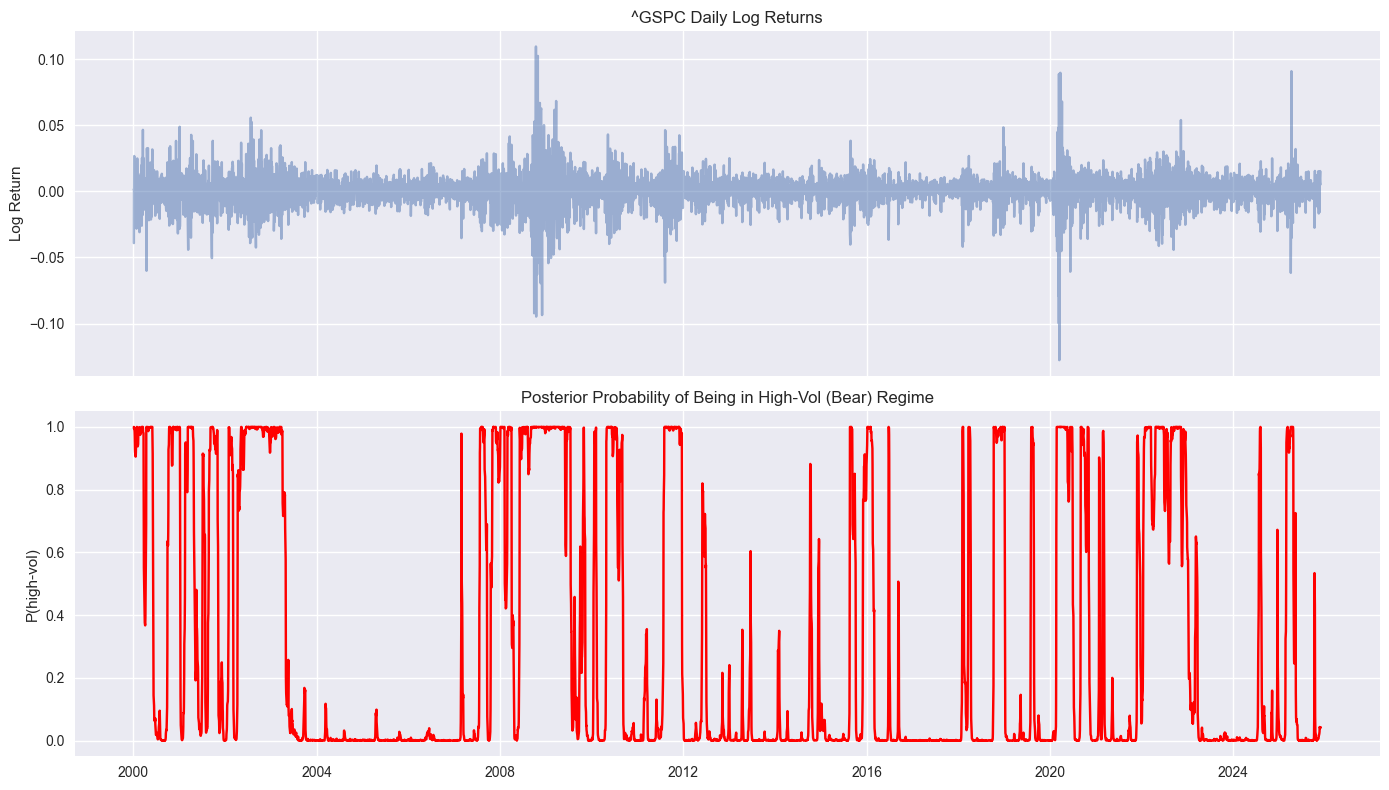

Saved figure: c:\DAT494\bayesian_regime_switching\results\figures\posterior_regime_probabilities.png


In [15]:
# Probability Plot + Returns

dates = data.index

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(dates, data['LogReturn'], alpha=0.5)
axes[0].set_title(f"{TICKER} Daily Log Returns")
axes[0].set_ylabel("Log Return")

axes[1].plot(dates, posterior_prob_highvol, color="red")
axes[1].set_title("Posterior Probability of Being in High-Vol (Bear) Regime")
axes[1].set_ylabel("P(high-vol)")
axes[1].set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

fig_path = os.path.join(FIGURES_DIR, "posterior_regime_probabilities.png")
fig.savefig(fig_path, dpi=200)
print("Saved figure:", fig_path)


## Overlay Shaded Regimes on Returns

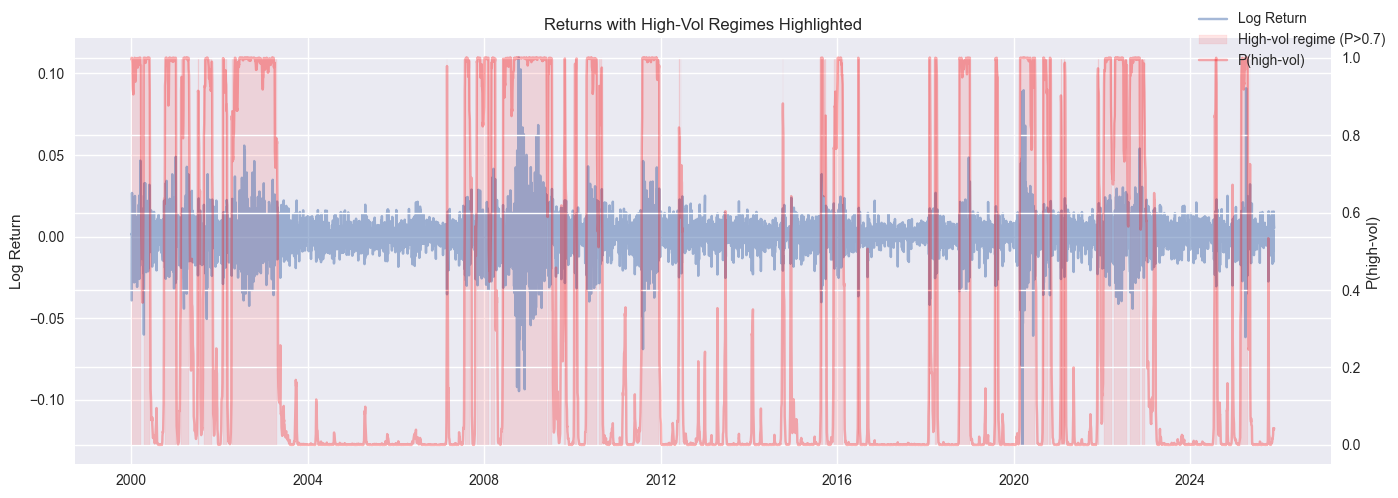

Saved figure: c:\DAT494\bayesian_regime_switching\results\figures\returns_with_shaded_regimes.png


In [16]:
# Shaded plot

threshold = 0.7  # highlight times when P(high-vol) > 0.7

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(dates, data['LogReturn'], alpha=0.5, label="Log Return")

ax2 = ax.twinx()
ax2.plot(dates, posterior_prob_highvol, color="red", alpha=0.3, label="P(high-vol)")
ax2.set_ylim(-0.05, 1.05)

# Shade high-vol periods
high_vol_mask = posterior_prob_highvol > threshold
ax.fill_between(
    dates,
    data['LogReturn'].min(),
    data['LogReturn'].max(),
    where=high_vol_mask,
    color="red",
    alpha=0.1,
    label="High-vol regime (P>0.7)"
)

ax.set_title("Returns with High-Vol Regimes Highlighted")
ax.set_ylabel("Log Return")
ax2.set_ylabel("P(high-vol)")

fig.legend(loc="upper right")
plt.tight_layout()
plt.show()

fig_path = os.path.join(FIGURES_DIR, "returns_with_shaded_regimes.png")
fig.savefig(fig_path, dpi=200)
print("Saved figure:", fig_path)


## Save Posterior Outputs

In [17]:
# Save key results

posterior_df = pd.DataFrame({
    "Date": dates,
    "LogReturn": data['LogReturn'].values,
    "PosteriorProb_HighVol": posterior_prob_highvol
}).set_index("Date")

posterior_path = os.path.join(RESULTS_DIR, "posterior_regime_probabilities.csv")
posterior_df.to_csv(posterior_path)
print("Saved posterior regime probabilities to:", posterior_path)

# Optionally save parameter summaries
param_summary = {
    "mu_mean": mus_post.mean(axis=0),
    "mu_std": mus_post.std(axis=0),
    "sigma_mean": sigmas_post.mean(axis=0),
    "sigma_std": sigmas_post.std(axis=0),
}
param_summary


Saved posterior regime probabilities to: c:\DAT494\bayesian_regime_switching\results\posterior_regime_probabilities.csv


{'mu_mean': array([ 0.00080148, -0.00107701]),
 'mu_std': array([0.00010859, 0.00045449]),
 'sigma_mean': array([0.00704608, 0.01952555]),
 'sigma_std': array([0.00011745, 0.00040114])}

# Model Diagnostics & Convergence 

In [23]:
import os
import matplotlib.pyplot as plt

diag_dir = os.path.join(FIGURES_DIR, "diagnostics")
os.makedirs(diag_dir, exist_ok=True)

plt.style.use("seaborn-v0_8")


# Burn-in already defined above, e.g. burn_in = 500
mus_post = samples_mus[burn_in:, :]                    # (N_post, 2)
sigmas_post = np.sqrt(samples_sigmas2[burn_in:, :])    # convert to std
A_post = samples_A[burn_in:, :, :]                     # (N_post, 2, 2)

N_post = mus_post.shape[0]
print("Post–burn-in samples:", N_post)

Post–burn-in samples: 1500


Saved: c:\DAT494\bayesian_regime_switching\results\figures\diagnostics\trace_mu.png


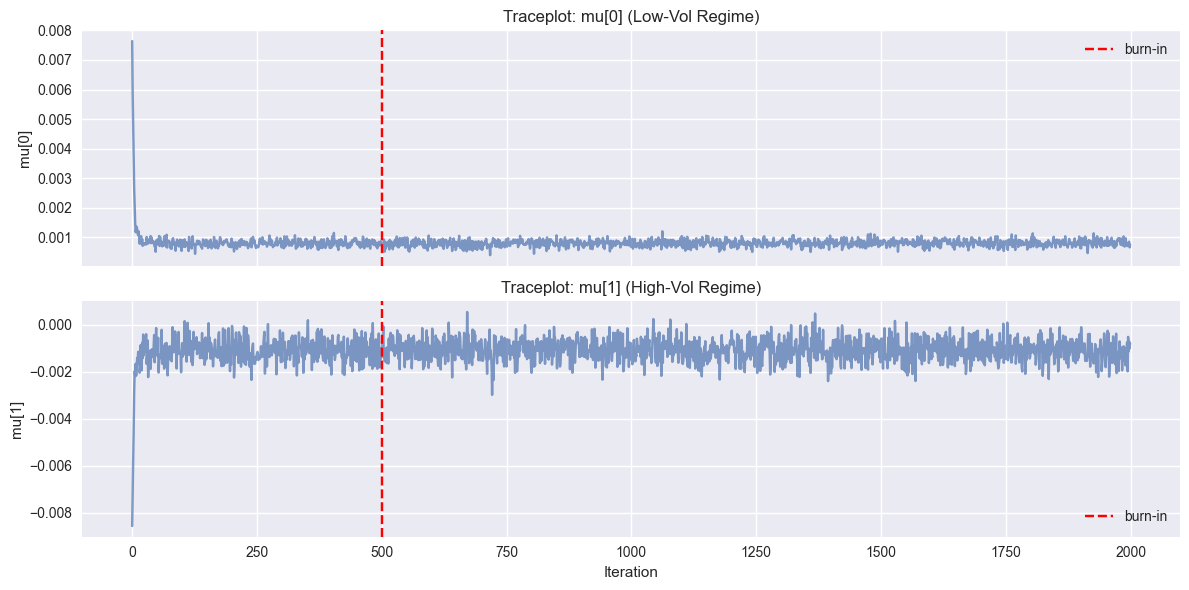

In [24]:
# Traceplot for mu[0] and mu[1]
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# mu[0]
axes[0].plot(samples_mus[:, 0], alpha=0.7)
axes[0].axvline(burn_in, color="red", linestyle="--", label="burn-in")
axes[0].set_title("Traceplot: mu[0] (Low-Vol Regime)")
axes[0].set_ylabel("mu[0]")
axes[0].legend()

# mu[1]
axes[1].plot(samples_mus[:, 1], alpha=0.7)
axes[1].axvline(burn_in, color="red", linestyle="--", label="burn-in")
axes[1].set_title("Traceplot: mu[1] (High-Vol Regime)")
axes[1].set_ylabel("mu[1]")
axes[1].set_xlabel("Iteration")
axes[1].legend()

plt.tight_layout()

save_path = os.path.join(diag_dir, "trace_mu.png")
fig.savefig(save_path, dpi=200)
print("Saved:", save_path)



Saved: c:\DAT494\bayesian_regime_switching\results\figures\diagnostics\trace_sigma.png


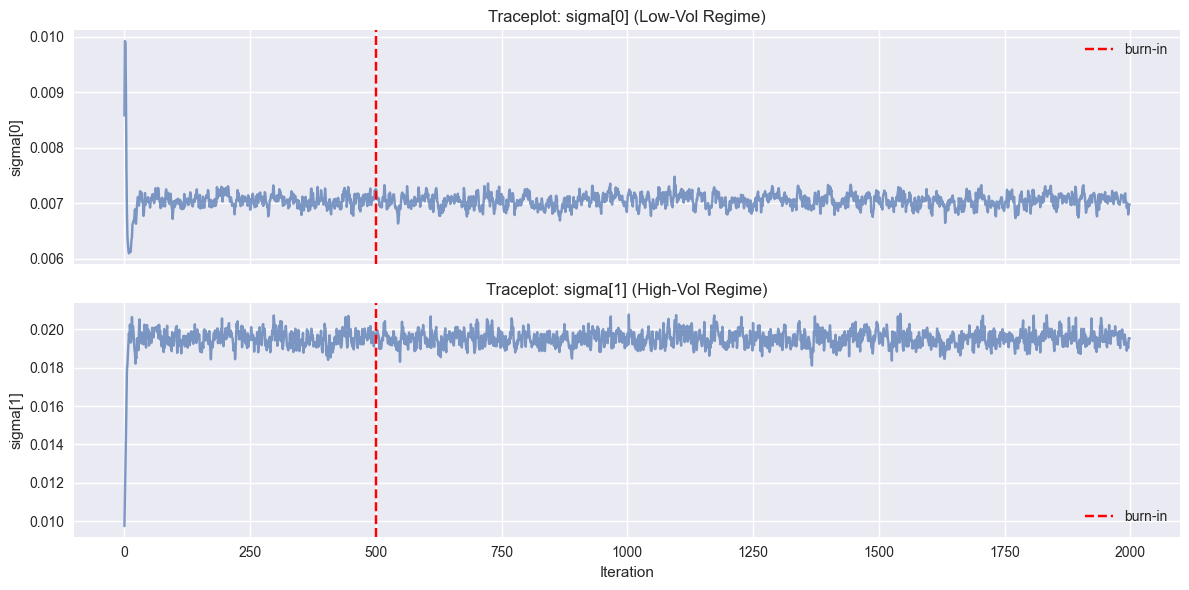

In [25]:
# Full-chain (pre-burn-in) sigma values for plotting against burn-in line
full_sigma0 = np.sqrt(samples_sigmas2[:, 0])
full_sigma1 = np.sqrt(samples_sigmas2[:, 1])

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# sigma[0]
axes[0].plot(full_sigma0, alpha=0.7)
axes[0].axvline(burn_in, color="red", linestyle="--", label="burn-in")
axes[0].set_title("Traceplot: sigma[0] (Low-Vol Regime)")
axes[0].set_ylabel("sigma[0]")
axes[0].legend()

# sigma[1]
axes[1].plot(full_sigma1, alpha=0.7)
axes[1].axvline(burn_in, color="red", linestyle="--", label="burn-in")
axes[1].set_title("Traceplot: sigma[1] (High-Vol Regime)")
axes[1].set_ylabel("sigma[1]")
axes[1].set_xlabel("Iteration")
axes[1].legend()

plt.tight_layout()

save_path = os.path.join(diag_dir, "trace_sigma.png")
fig.savefig(save_path, dpi=200)
print("Saved:", save_path)


Saved: c:\DAT494\bayesian_regime_switching\results\figures\diagnostics\trace_transition_probs.png


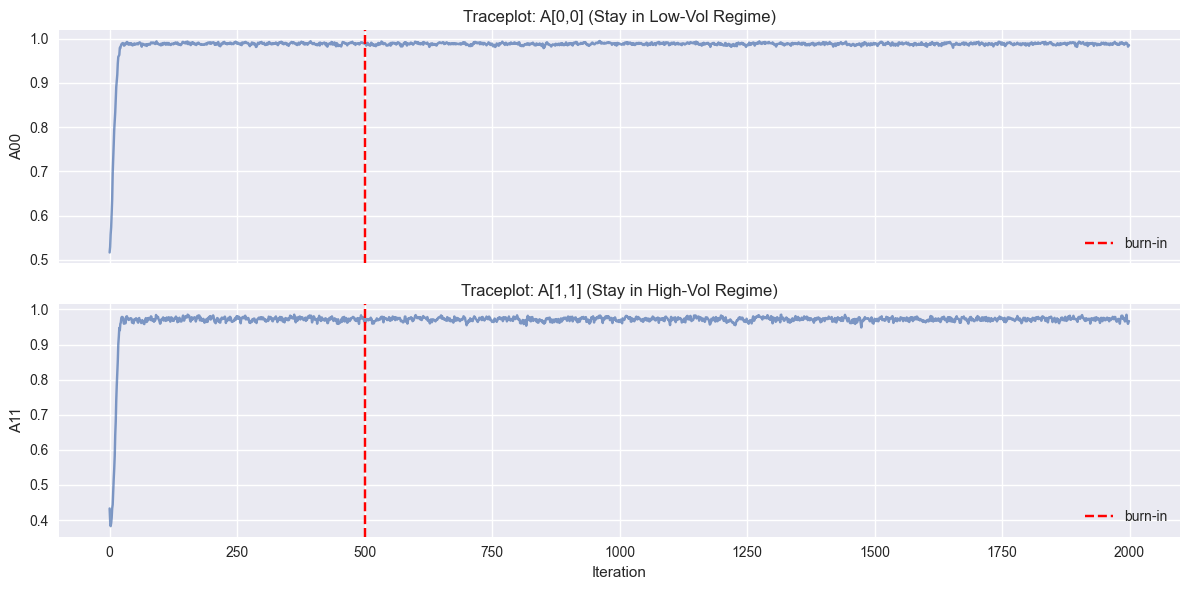

In [26]:
A00_chain = samples_A[:, 0, 0]  # probability of staying in low-vol
A11_chain = samples_A[:, 1, 1]  # probability of staying in high-vol

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# A00
axes[0].plot(A00_chain, alpha=0.7)
axes[0].axvline(burn_in, color="red", linestyle="--", label="burn-in")
axes[0].set_title("Traceplot: A[0,0] (Stay in Low-Vol Regime)")
axes[0].set_ylabel("A00")
axes[0].legend()

# A11
axes[1].plot(A11_chain, alpha=0.7)
axes[1].axvline(burn_in, color="red", linestyle="--", label="burn-in")
axes[1].set_title("Traceplot: A[1,1] (Stay in High-Vol Regime)")
axes[1].set_ylabel("A11")
axes[1].set_xlabel("Iteration")
axes[1].legend()

plt.tight_layout()

save_path = os.path.join(diag_dir, "trace_transition_probs.png")
fig.savefig(save_path, dpi=200)
print("Saved:", save_path)



## Autocorrelation of Posterior Samples

In [29]:
def autocorr(x, max_lag=50):
    x = np.asarray(x)
    x = x - x.mean()
    result = np.correlate(x, x, mode='full')
    acf = result[result.size // 2:] / result[result.size // 2]
    return acf[:max_lag+1]

In [30]:
max_lag = 50

params_for_acf = {
    "mu[0]": mus_post[:, 0],
    "mu[1]": mus_post[:, 1],
    "sigma[0]": sigmas_post[:, 0],
    "sigma[1]": sigmas_post[:, 1],
    "A00": A_post[:, 0, 0],
    "A11": A_post[:, 1, 1],
}


Saved ACF figure to: c:\DAT494\bayesian_regime_switching\results\figures\diagnostics\acf_parameters.png


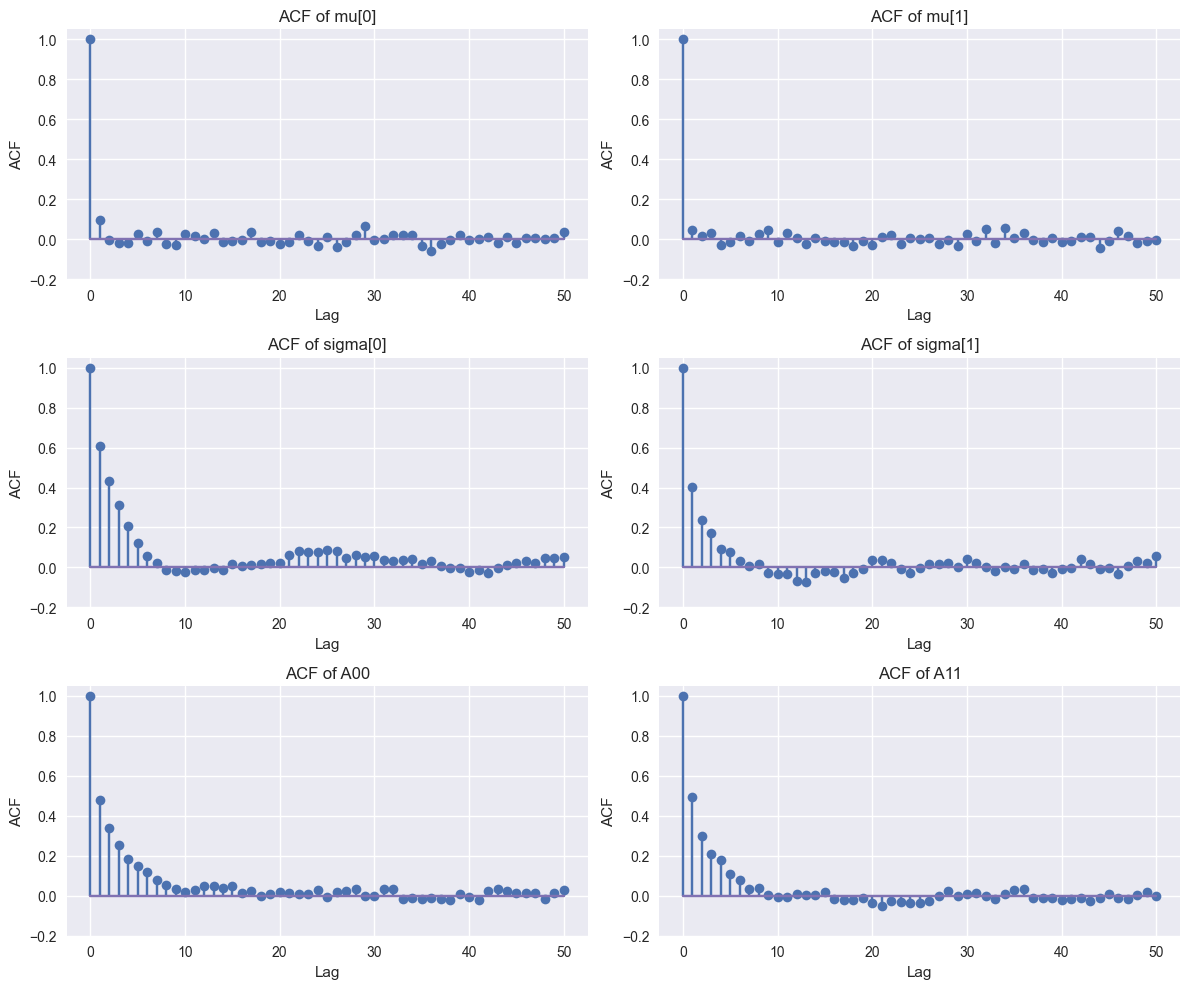

In [31]:
import os
import matplotlib.pyplot as plt

diag_dir = os.path.join(FIGURES_DIR, "diagnostics")
os.makedirs(diag_dir, exist_ok=True)

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, chain) in zip(axes, params_for_acf.items()):
    acf_vals = autocorr(chain, max_lag=max_lag)
    lags = np.arange(len(acf_vals))
    
    # NOTE: removed use_line_collection to avoid TypeError
    markerline, stemlines, baseline = ax.stem(lags, acf_vals)
    
    ax.set_title(f"ACF of {name}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")
    ax.set_ylim(-0.2, 1.05)

plt.tight_layout()

save_path = os.path.join(diag_dir, "acf_parameters.png")
fig.savefig(save_path, dpi=200)
print("Saved ACF figure to:", save_path)


## Effective Sample Size (ESS)

In [32]:
def effective_sample_size(chain, max_lag=100):
    """
    Basic ESS estimate using autocorrelations up to max_lag or until ACF < 0.
    """
    chain = np.asarray(chain)
    n = len(chain)
    acf_vals = autocorr(chain, max_lag=max_lag)
    
    # ignore lag 0 (always 1)
    acf_tail = acf_vals[1:]
    
    # truncate when ACF becomes negative
    positive_acf = acf_tail[acf_tail > 0]
    if len(positive_acf) == 0:
        return n  # essentially iid
    
    tau = 1 + 2 * positive_acf.sum()
    ess = n / tau
    return ess


In [35]:
ess_results = {}

for name, chain in params_for_acf.items():
    ess_results[name] = effective_sample_size(chain, max_lag=100)

ess_results

for name, ess in ess_results.items():
    print(f"{name}: ESS ≈ {ess:.1f}")

mu[0]: ESS ≈ 471.1
mu[1]: ESS ≈ 585.1
sigma[0]: ESS ≈ 180.5
sigma[1]: ESS ≈ 300.6
A00: ESS ≈ 217.4
A11: ESS ≈ 322.8


In [41]:
ess_df = pd.DataFrame.from_dict(ess_results, orient="index", columns=["ESS"])
ess_path = os.path.join(RESULTS_DIR, "ess_summary.csv")
ess_df.to_csv(ess_path)
print("Saved ESS summary to:", ess_path)

Saved ESS summary to: c:\DAT494\bayesian_regime_switching\results\ess_summary.csv


## Check Burn-in Choice

In [37]:
# Compare Posterior Means Under Different Burn-ins

def summarize_with_burnin(b):
    mus_b = samples_mus[b:, :]
    sigmas_b = np.sqrt(samples_sigmas2[b:, :])
    A_b = samples_A[b:, :, :]
    return {
        "burn_in": b,
        "mu_mean": mus_b.mean(axis=0),
        "sigma_mean": sigmas_b.mean(axis=0),
        "A00_mean": A_b[:, 0, 0].mean(),
        "A11_mean": A_b[:, 1, 1].mean()
    }

for b in [0, 200, 500, 800]:
    summary_b = summarize_with_burnin(b)
    print(summary_b)


{'burn_in': 0, 'mu_mean': array([ 0.0008142 , -0.00109762]), 'sigma_mean': array([0.00704695, 0.01950794]), 'A00_mean': np.float64(0.9859652353019642), 'A11_mean': np.float64(0.9682334750866548)}
{'burn_in': 200, 'mu_mean': array([ 0.00080114, -0.00108129]), 'sigma_mean': array([0.00704699, 0.01952552]), 'A00_mean': np.float64(0.9881306820472855), 'A11_mean': np.float64(0.9718260264247964)}
{'burn_in': 500, 'mu_mean': array([ 0.00080148, -0.00107701]), 'sigma_mean': array([0.00704608, 0.01952555]), 'A00_mean': np.float64(0.9880303296850516), 'A11_mean': np.float64(0.9717601233418944)}
{'burn_in': 800, 'mu_mean': array([ 0.00080528, -0.00108218]), 'sigma_mean': array([0.00704825, 0.01952822]), 'A00_mean': np.float64(0.9880070990788647), 'A11_mean': np.float64(0.9717045713950825)}


## Diagnostics for State Sequence

In [38]:
stored_states_arr = np.array(stored_states)  # shape (N_post, T)
print("Stored states shape:", stored_states_arr.shape)

# fraction of time in state 1 (high-vol) for each draw
frac_high_each_draw = stored_states_arr.mean(axis=1)

print("Mean fraction high-vol across draws:", frac_high_each_draw.mean())
print("Std  fraction high-vol across draws:", frac_high_each_draw.std())


Stored states shape: (1500, 6516)
Mean fraction high-vol across draws: 0.2988175772457541
Std  fraction high-vol across draws: 0.011524052261728939


Saved histogram to: c:\DAT494\bayesian_regime_switching\results\figures\diagnostics\state_sequence_hist.png


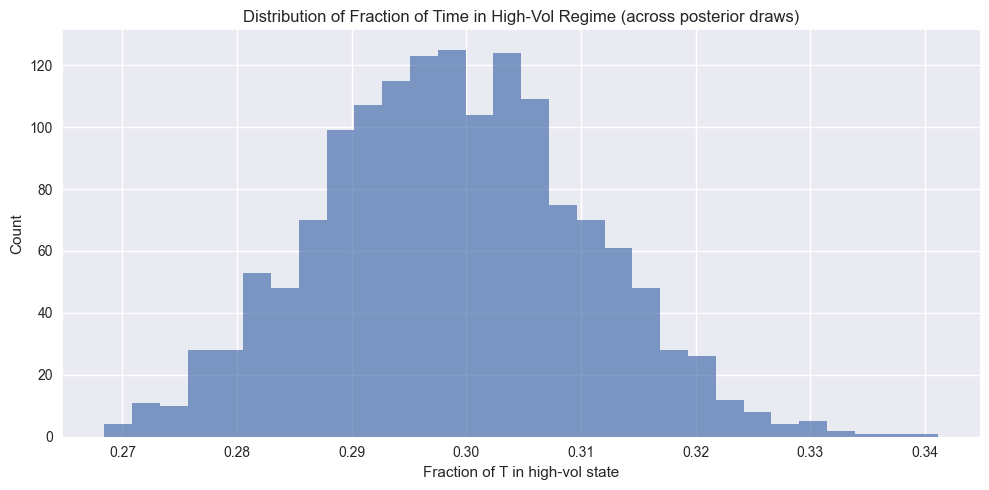

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(frac_high_each_draw, bins=30, alpha=0.7)

ax.set_title("Distribution of Fraction of Time in High-Vol Regime (across posterior draws)")
ax.set_xlabel("Fraction of T in high-vol state")
ax.set_ylabel("Count")

plt.tight_layout()

# Save figure
save_path = os.path.join(diag_dir, "state_sequence_hist.png")
fig.savefig(save_path, dpi=200)
print("Saved histogram to:", save_path)

plt.show()